In [1]:
import math
from simtk import unit
from simtk.openmm import openmm as mm
from simtk.openmm import app as app
from openmmtools import testsystems, states, mcmc
from openmmtools import multistate
testsystem = testsystems.AlanineDipeptideExplicit()
import os
import tempfile
import numpy as np
import mdtraj as md
from copy import deepcopy

from pylab import *
from math import pi
import random

In [2]:
class Replica(object):
    def __init__(self, system, topology, solute, solvent, device_id):
        self.system = system
        self.topology = topology
        
        self.device_id = device_id
        
        self.solute = solute
        self.solvent = solvent
        
        self.temps = {'solvent': 300*unit.kelvin, 'solute': 1200*unit.kelvin}
        self.frictions = {'solvent': 25 / unit.picosecond, 'solute': 25 / unit.picosecond}
        self.time_step = 1.0 * unit.femtosecond
        self.pressure = 1 * unit.atmospheres
        
        
        self.vanilla_forces = []
        #put each force in sperae group
        for force_index, force in enumerate(self.system.getForces()):
            
            #save the nonbonded force to manipulate later
            if isinstance(force, mm.NonbondedForce):
                self.nonbonded_force = force
            
            force.setForceGroup(force_index)
            self.vanilla_forces.append(force_index)
            
        self.prot_force_idx, self.water_force_idx = self.add_solv_solu_forces()
        
        self.simulation = self.build_simulation()
            
    def add_solv_solu_forces(self):

        protien = deepcopy(self.nonbonded_force)
        mute_nonbonded(protien, solvent)
        self.system.addForce(protien)
        protein_force_idx = max(self.vanilla_forces)+1
        protien.setForceGroup(protein_force_idx)

        water_water = deepcopy(self.nonbonded_force)
        mute_nonbonded(water_water, solute)
        system.addForce(water_water)
        water_force_idx = max(self.vanilla_forces)+2
        water_water.setForceGroup(water_force_idx)

        return(protein_force_idx, water_force_idx)
    
    def build_simulation(self):

        integrator = mm.NoseHooverIntegrator(self.time_step)
        integrator.addSubsystemThermostat(self.solvent, [], self.temps['solvent'],
                                          self.frictions['solvent'], self.temps['solvent'],
                                          self.frictions['solvent'], 3,3,3)
        
        integrator.addSubsystemThermostat(self.solute, [], self.temps['solute'],
                                          self.frictions['solute'], self.temps['solute'],
                                          self.frictions['solute'], 3,3,3)

        integrator.setIntegrationForceGroups(set(self.vanilla_forces)) 


        integrator.setConstraintTolerance(0.00001)

        platform = mm.Platform.getPlatformByName('CUDA')
        properties = {'CudaPrecision': 'mixed', 'CudaDeviceIndex': self.device_id}

        sim = app.Simulation(self.topology, self.system, integrator, platform, properties)

        return {'sim': sim, 'integrate': integrator}
    
    def get_energy(self, sub_sys='all'):
        sub_systems = {'solvent': [self.water_force_idx], 'solute': [self.prot_force_idx], 'all': self.vanilla_forces}
        index = sub_systems[sub_sys]
        return self.simulation['sim'].context.getState(getEnergy=True, groups=set(index)).getPotentialEnergy()
    
    def get_interaction_energy(self, interaction, positions=None):
        
        if positions is not None:
            current_pos = self.simulation['sim'].context.getState(getPositions=True).getPositions()
            self.simulation['sim'].context.setPositions(positions)
        
        if interaction == 'ww':
            energy = self.get_energy('solvent')
        elif interaction == 'pp':
            energy = self.get_energy('solute')
        elif interaction == 'pw':
            energy = self.get_energy('all')-self.get_energy('solvent')-self.get_energy('solute')
        else:
            raise ValueError('Unkown interaction. Use: pp, pw, ww')
        
        #restore positions of context
        if positions is not None:
            self.simulation['sim'].context.setPositions(current_pos)
            
        return energy
            
    def get_solute_temp(self):
        return self.simulation['integrate'].getTemperature(1)
    
    def get_solvent_temp(self):
        return self.simulation['integrate'].getTemperature(0) 
        
    def set_solute_temp(self, temp):
        self.simulation['integrate'].setTemperature(temp, 1)
        
    def set_solvent_temp(self, temp):
        self.simulation['integrate'].setTemperature(temp, 0)   
        
        
def mute_nonbonded(force, atoms):
    for atom in atoms:
        force.setParticleParameters(atom, 0.0, 1.0, 0.0)           

    
    
        

In [3]:
# CONSTANTS #
kB = 0.008314472471220214 * unit.kilojoules_per_mole/unit.kelvin

class REST(object):
    def __init__(self, system , topo, positions, solute, solvent, tempratures):
        self.temps = tempratures
        self.positions = positions
        self.system = system
        self.replicas = [Replica(deepcopy(self.system), topo, solute, solvent, device_id='0') for t in self.temps]
        self.pos = positions
        for rep, t in zip(self.replicas, self.temps):
            #REST1 vs REST2
            rep.set_solvent_temp(t)
            rep.set_solute_temp(t)

            
    def serial_simulation(self):
        #init all reps
        for i, rep in enumerate(self.replicas):
            sim = rep.simulation['sim']
            sim.context.setPositions(self.positions)
            print('Minimizing replica {}'.format(i))
            sim.minimizeEnergy()
            sim.context.setVelocitiesToTemperature(300*unit.kelvin)
            print('Equilibrating replica {}'.format(i))
            sim.step(10)
            if i == 0:
                sim.reporters.append(app.StateDataReporter('./ala_rest.dat', 50, step=True,
                                                       potentialEnergy=True, volume=True, temperature=True, progress=True,
                                                       remainingTime=True, speed=True, totalSteps=1000, separator='\t'))
                sim.reporters.append(app.DCDReporter('ala_rest.dcd', 50))
        
        for step in range(100):
            #propogate all reps
            for i, rep in enumerate(self.replicas):  
                sim = rep.simulation['sim']
                
                print('Running production for replica {}'.format(i))
                sim.step(100)
                print('Done!')

            #swap reps
            for i, rep in enumerate(self.replicas):  
                if i != len(self.replicas)-1:
                    delta = self.get_acceptance_probability(rep, self.replicas[i+1])
                    if metrop(delta):
                        print('Swap rep{} for rep{}'.format(i, i+1))
                        self.swap_reps(rep, self.replicas[i+1])
            
    def get_acceptance_probability(self, rep1, rep2):
        
        bn = 1/(kB*rep1.get_solute_temp())
        bm = 1/(kB*rep2.get_solute_temp())
        
        Xm = rep2.simulation['sim'].context.getState(getPositions=True).getPositions()
        
        #Some optimizations could be done here to reduce the number
        #of times postions are set and energies are calculated
        EpXn = rep1.get_interaction_energy('pp') #positions Xn are implicit
        EpwXn = rep1.get_interaction_energy('pw') #positions Xn are implicit
        
        EpXm = rep1.get_interaction_energy('pp', Xm)
        EpwXm = rep1.get_interaction_energy('pw', Xm)
        
        Xm_terms = EpXm + 0.5*EpwXm
        Xn_terms = EpXn + 0.5*EpwXn
        
        
        print('@@@@@@@@@@')
        print(EpXm, 0.5*EpwXm)
        print(EpXn, 0.5*EpwXn)
        
        print('###')
        print(Xm_terms)
        print(Xn_terms)
        print((bn - bm))
        
        #REST1 vs REST2
        delta = (bn - bm)*(Xm_terms-Xn_terms)
        
        return delta
    
    def swap_reps(self, rep1, rep2):
        #should swap box size for NPT
        Xm = rep2.simulation['sim'].context.getState(getPositions=True).getPositions()
        rep1.simulation['sim'].context.setPositions(Xm)
             
            
def metrop(delta):
    if delta <= 0:
        print('**100 percent')
        return True
    else:
        print('//////')
        prob = np.exp(-delta)
        print('{}percent'.format(prob*100))
        ##THE DISTRIBUTION OF THIS RANDOM NUMBER IS IMPORTANT
        if prob > random.random():
            return True
        else:
            return False

In [4]:
system = testsystem.system
topo = testsystem.topology
positions = testsystem.positions

##Needs to be auto detected
solute = list(range(22))
solvent = list(range(22, 2269))

rest = REST(system, topo, positions, solute, solvent, [300, 500])

In [5]:
rest.serial_simulation()

Minimizing replica 0
Equilibrating replica 0
Minimizing replica 1
Equilibrating replica 1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-125.61996979296521 kJ/mol -16733.2958003661 kJ/mol
-116.34382960399853 kJ/mol -15928.415950105358 kJ/mol
###
-16858.915770159067 kJ/mol
-16044.759779709357 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-130.19972658529332 kJ/mol -16172.723578157329 kJ/mol
-120.62345684257883 kJ/mol -15926.622112942077 kJ/mol
###
-16302.923304742622 kJ/mol
-16047.245569784656 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-136.3157646340528 kJ/mol -15489.391118593225 kJ/mol
-126.83741279282657 kJ/mol -15487.691298092359 kJ/mol
###
-15625.706883227278 kJ/mol
-15614.528710885186 kJ/mol
0.16036295001860248 mol/kJ
*

Done!
Running production for replica 1
Done!
@@@@@@@@@@
-143.88757353641284 kJ/mol -15077.416272055932 kJ/mol
-130.42255557072565 kJ/mol -15135.679744609717 kJ/mol
###
-15221.303845592345 kJ/mol
-15266.102300180442 kJ/mol
0.16036295001860248 mol/kJ
//////
0.07586178991413316percent
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-127.02777884289799 kJ/mol -15016.683464696309 kJ/mol
-138.0456005403214 kJ/mol -14999.173983336064 kJ/mol
###
-15143.711243539206 kJ/mol
-15137.219583876386 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-143.7973445395586 kJ/mol -15113.498999403304 kJ/mol
-136.12812502928233 kJ/mol -14973.393949469326 kJ/mol
###
-15257.296343942862 kJ/mol
-15109.522074498609 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@


Done!
@@@@@@@@@@
-142.69446653742318 kJ/mol -15407.68460403867 kJ/mol
-136.28754380039373 kJ/mol -15265.516862875536 kJ/mol
###
-15550.379070576093 kJ/mol
-15401.80440667593 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-155.34394179586104 kJ/mol -15254.089380389914 kJ/mol
-143.3208453198052 kJ/mol -15270.354987195618 kJ/mol
###
-15409.433322185776 kJ/mol
-15413.675832515424 kJ/mol
0.16036295001860248 mol/kJ
//////
50.6444026408126percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-145.86206877009096 kJ/mol -15303.371157435096 kJ/mol
-128.66120088439158 kJ/mol -15172.250682243359 kJ/mol
###
-15449.233226205188 kJ/mol
-15300.91188312775 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-154.71633378506652 kJ/mo

Done!
Running production for replica 1
Done!
@@@@@@@@@@
-144.17978329297415 kJ/mol -15294.87243023776 kJ/mol
-123.35703920266724 kJ/mol -15389.987951619045 kJ/mol
###
-15439.052213530733 kJ/mol
-15513.344990821712 kJ/mol
0.16036295001860248 mol/kJ
//////
0.0006697281022596989percent
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-158.87781755666293 kJ/mol -15358.314009812198 kJ/mol
-116.95686798062872 kJ/mol -15213.363119591244 kJ/mol
###
-15517.19182736886 kJ/mol
-15330.319987571873 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-143.758435710613 kJ/mol -15328.059921785889 kJ/mol
-129.4440388455024 kJ/mol -15270.84621998901 kJ/mol
###
-15471.818357496502 kJ/mol
-15400.290258834511 kJ/mol
0.16036295001860248 mol/kJ
**100 percent
Swap rep0 for rep1
Running production for replica 0
Done!
Running production for replica 1
Done!
@@@@@@@@@@
-1

In [6]:
##Analysis

In [7]:
traj = md.load_dcd('./ala_rest.dcd', testsystem.mdtraj_topology)

In [8]:
#atoms, bonds = traj.topology.to_dataframe()
#atoms

In [9]:
psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
angles = md.compute_dihedrals(traj, [phi_indices, psi_indices])

(-3.141592653589793, 3.141592653589793)

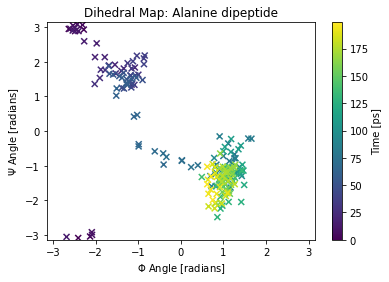

In [10]:
figure()
title('Dihedral Map: Alanine dipeptide')
scatter(angles[:, 0], angles[:, 1], marker='x', c=traj.time)
cbar = colorbar()
cbar.set_label('Time [ps]')
xlabel(r'$\Phi$ Angle [radians]')
xlim(-pi, pi)
ylabel(r'$\Psi$ Angle [radians]')
ylim(-pi, pi)

(-3.141592653589793, 3.141592653589793)

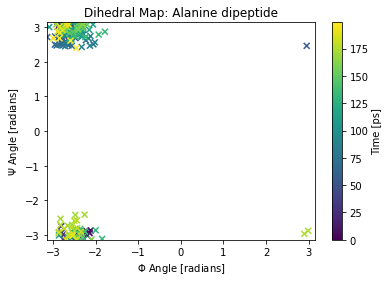

In [9]:
#300k
figure()
title('Dihedral Map: Alanine dipeptide')
scatter(angles[:, 0], angles[:, 1], marker='x', c=traj.time)
cbar = colorbar()
cbar.set_label('Time [ps]')
xlabel(r'$\Phi$ Angle [radians]')
xlim(-pi, pi)
ylabel(r'$\Psi$ Angle [radians]')
ylim(-pi, pi)